# borderline-SMOTE

1. Random Forest Classifier
2. Bagging Classifier
3. XGBoost
4. Gradient Boosting 
5. Extra Trees
6. Gaussian Naïve Bayes
7. CART
8. KNN
9. AdaBoost

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from time import time
import warnings
from sklearn.model_selection import train_test_split
# Over sampling the training data
from imblearn.over_sampling import BorderlineSMOTE

warnings.filterwarnings("ignore")

# Reading the file
df = pd.read_csv("all_three.csv")

# Dropping the first column because it is of no use  
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Segregating the features and labels 
Y = df[['label']]
X = df[['rec/sent','amount','size','weight','version','lock_time','is_coinbase',
        'has_witness','input_count','output_count','input_total_usd','output_total_usd',
        'fee_usd','fee_per_kb_usd','fee_per_kwu_usd','cdd_total']]

# Decimal point normalization (scaling each column by its max power of 10)
for col in X.columns: 
    max_val = X[col].max()
    q = len(str(abs(int(max_val)))) if max_val != 0 else 1
    X[col] = X[col] / (10**q)

# Splitting the data (60-40 split)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y) 

# Oversampling using SMOTE
Borderline_SMOTE = BorderlineSMOTE() 
x_train, y_train = Borderline_SMOTE.fit_resample(x_train, y_train)



In [2]:
!pip install seaborn

In [3]:
# -----------------------------
# Required imports
# -----------------------------
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as mplplt  # renamed to avoid overwriting issues
import psutil, os
import pandas as pd
import numpy as np
from time import time

# -----------------------------
# Full check_prediction function
# -----------------------------
def check_prediction(y_true, y_pred, start_time, model=None, x_test=None, x_train=None): 
    runtime_sec = time() - start_time
    
    # RAM usage
    process = psutil.Process(os.getpid())
    ram_used_mb = process.memory_info().rss / (1024 * 1024)
    
    # Base metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)

    # ROC AUC
    roc_auc = None
    y_probs = None
    try:
        if model is not None and x_test is not None:
            if hasattr(model, "predict_proba"):
                y_probs = model.predict_proba(x_test)
            elif hasattr(model, "decision_function"):
                y_probs = model.decision_function(x_test)

        if y_probs is not None:
            classes = np.unique(y_true)
            y_true_bin = label_binarize(y_true, classes=classes)
            roc_auc = roc_auc_score(y_true_bin, y_probs, average="weighted", multi_class="ovr")
    except Exception as e:
        print(f"⚠ ROC AUC not available: {e}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print metrics
    print("\n===== Evaluation Results =====")
    print(f"runtime_sec: {runtime_sec:.4f}")
    print(f"ram_used_mb: {ram_used_mb:.4f}")
    print(f"accuracy: {acc:.4f}")
    print(f"precision: {prec:.4f}")
    print(f"recall: {rec:.4f}")
    print(f"roc_auc: {roc_auc:.4f}" if roc_auc else "roc_auc: N/A")
    print("confusion_matrix:\n", cm)
    print("================================\n")

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

    # -----------------------------
    # Confusion Matrix Heatmap
    # -----------------------------
    fig_cm, ax_cm = mplplt.subplots(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax_cm)
    ax_cm.set_title("Confusion Matrix")
    ax_cm.set_xlabel("Predicted")
    ax_cm.set_ylabel("True")
    mplplt.show()

    # -----------------------------
    # ROC Curve plotting
    # -----------------------------
    if y_probs is not None:
        try:
            if y_probs.ndim > 1 and y_probs.shape[1] > 1:  # multiclass
                n_classes = y_probs.shape[1]
                classes = np.unique(y_true)
                y_true_bin = label_binarize(y_true, classes=classes)

                fig_roc, ax_roc = mplplt.subplots(figsize=(7,6))
                for i in range(n_classes):
                    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
                    roc_auc_val = auc(fpr, tpr)
                    ax_roc.plot(fpr, tpr, label=f"Class {classes[i]} (AUC={roc_auc_val:.2f})")

                ax_roc.plot([0,1],[0,1],'k--')
                ax_roc.set_title("ROC Curves (Multiclass)")
                ax_roc.set_xlabel("False Positive Rate")
                ax_roc.set_ylabel("True Positive Rate")
                ax_roc.legend(loc="lower right")
                mplplt.show()
            else:  # binary
                if len(np.unique(y_true)) == 2:
                    fpr, tpr, _ = roc_curve(y_true, y_probs)
                    roc_auc_val = auc(fpr, tpr)
                    fig_roc, ax_roc = mplplt.subplots(figsize=(7,6))
                    ax_roc.plot(fpr, tpr, label=f"AUC={roc_auc_val:.2f}")
                    ax_roc.plot([0,1],[0,1],'k--')
                    ax_roc.set_title("ROC Curve (Binary)")
                    ax_roc.set_xlabel("False Positive Rate")
                    ax_roc.set_ylabel("True Positive Rate")
                    ax_roc.legend(loc="lower right")
                    mplplt.show()
        except Exception as e:
            print(f"⚠ ROC plotting failed: {e}")

    # -----------------------------
    # Feature Correlation Heatmap
    # -----------------------------
    if x_train is not None:
        corr = pd.DataFrame(x_train).corr()
        fig_corr, ax_corr = mplplt.subplots(figsize=(10, 8))
        sns.heatmap(corr, cmap="coolwarm", annot=False, ax=ax_corr)
        ax_corr.set_title("Feature Correlation Heatmap")
        mplplt.show()


In [4]:
df['label'].value_counts()
print("training data size")
print(y_train.value_counts())
print("testing data size")
print(y_test.value_counts())

training data size
label
0        235092
1        235092
2        235092
3        235092
Name: count, dtype: int64
testing data size
label
0        100755
2         16617
3         10240
1           676
Name: count, dtype: int64


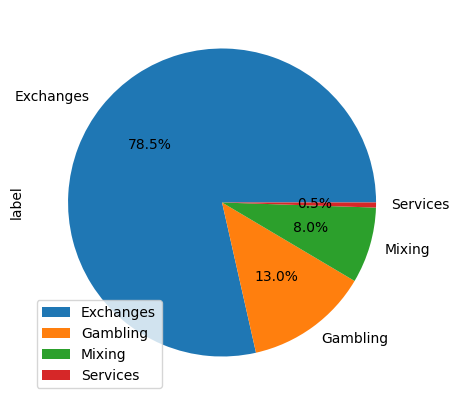

In [5]:
pf2=pd.DataFrame({'label':df['label'].value_counts().to_list()},
                    index=['Exchanges','Gambling', 'Mixing','Services'])

plt=pf2.plot.pie(y='label',autopct='%1.1f%%',figsize=(5,5))

## Random Forest Classifier


===== Evaluation Results =====
runtime_sec: 464.8765
ram_used_mb: 811.5000
accuracy: 0.9618
precision: 0.9634
recall: 0.9618
roc_auc: 0.9908
confusion_matrix:
 [[97915    53    12  2775]
 [  231   440     0     5]
 [   11     0 16606     0]
 [ 1811     5     0  8424]]


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    100755
           1       0.88      0.65      0.75       676
           2       1.00      1.00      1.00     16617
           3       0.75      0.82      0.79     10240

    accuracy                           0.96    128288
   macro avg       0.90      0.86      0.88    128288
weighted avg       0.96      0.96      0.96    128288



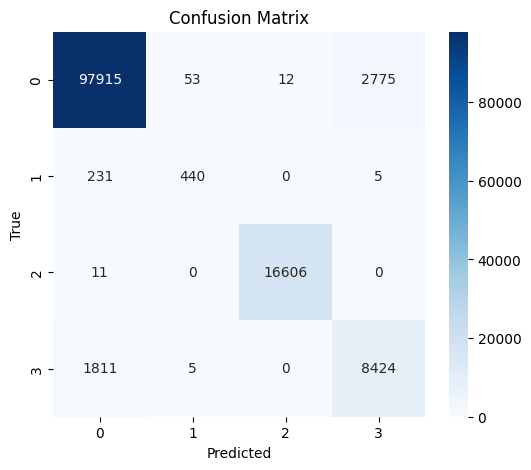

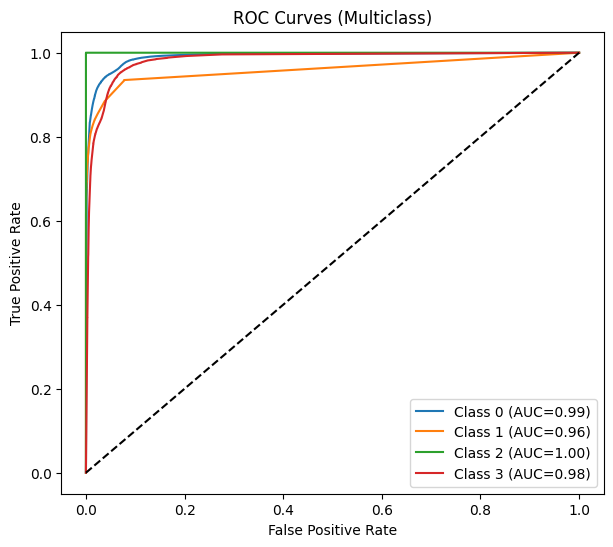

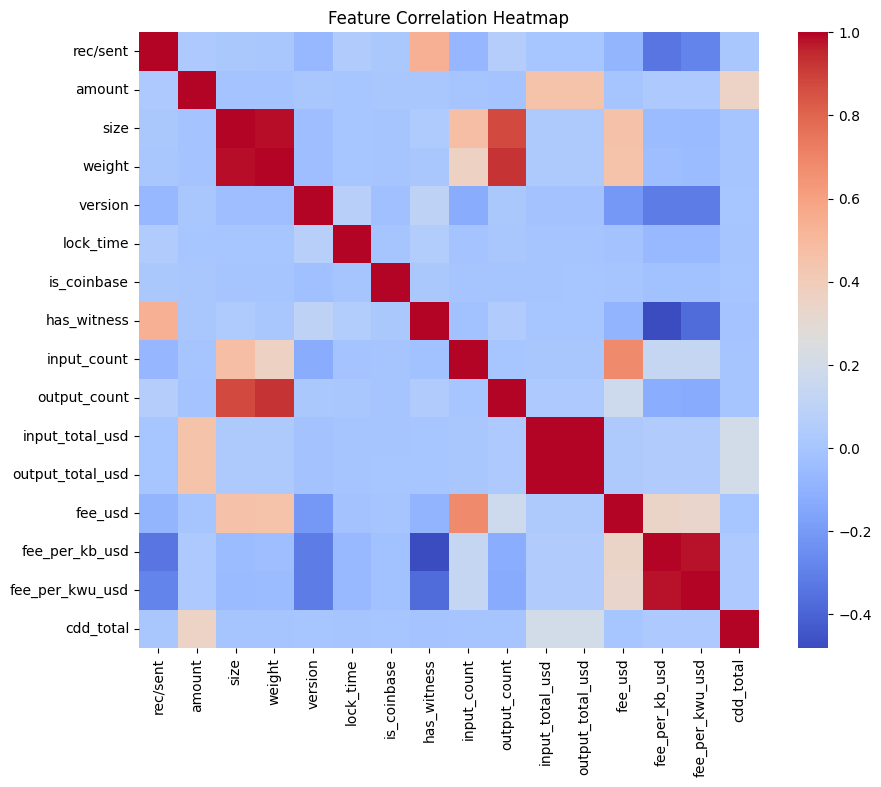

In [6]:
start_time = time()
from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier()  
model.fit(x_train, y_train) 

# predicting the model in testing dataset
y_pred = model.predict(x_test)

# Evaluating the model 
check_prediction(y_test, y_pred, start_time, model, x_test, x_train)

## Bagging Classifier

Cross-validation scores: [0.97021229 0.96981942 0.96972099]
Mean CV score: 0.9699

===== Evaluation Results =====
runtime_sec: 1335.3486
ram_used_mb: 645.8398
accuracy: 0.9577
precision: 0.9603
recall: 0.9577
roc_auc: 0.9869
confusion_matrix:
 [[97404   118    22  3211]
 [  227   436     4     9]
 [   13     0 16603     1]
 [ 1818     8     1  8413]]


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.97    100755
           1       0.78      0.64      0.70       676
           2       1.00      1.00      1.00     16617
           3       0.72      0.82      0.77     10240

    accuracy                           0.96    128288
   macro avg       0.87      0.86      0.86    128288
weighted avg       0.96      0.96      0.96    128288



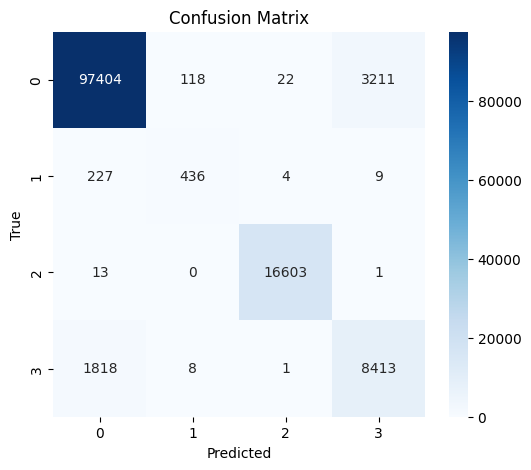

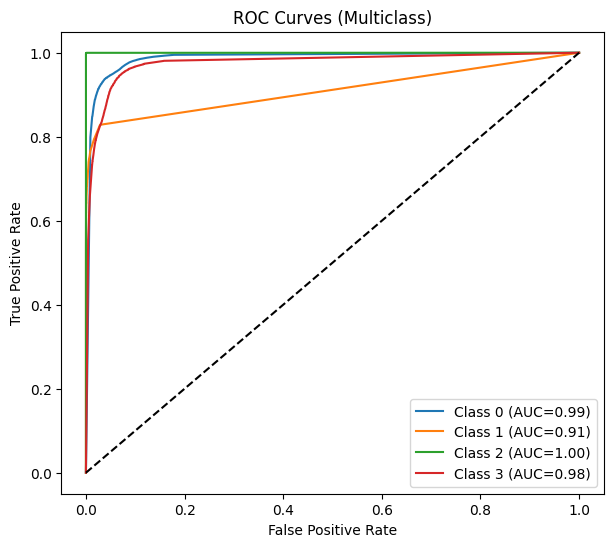

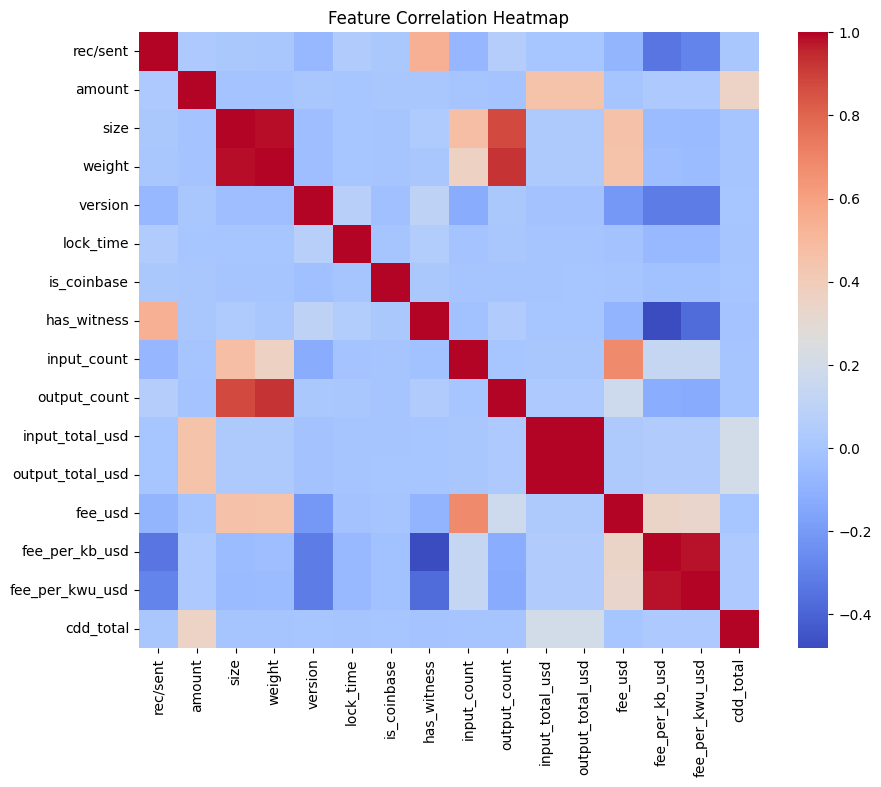

In [7]:
from time import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold, cross_val_score

# Start timer
current_time = time()

# Initialize the base classifier
base_model = DecisionTreeClassifier()

# Number of base classifiers
n_trees = 50

# Initialize BaggingClassifier (use 'estimator' instead of 'base_estimator')
model = BaggingClassifier(
    estimator=base_model,  # updated argument name
    n_estimators=n_trees,
    random_state=50
)

# Optional: Cross-validation score
kfold = KFold(n_splits=3, shuffle=True, random_state=50)
res = cross_val_score(model, X, Y.values.ravel(), cv=kfold)
print(f"Cross-validation scores: {res}")
print(f"Mean CV score: {res.mean():.4f}")

# Train the model
model.fit(x_train, y_train.values.ravel())

# Predict
y_pred = model.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=model,        # needed for ROC AUC
    x_test=x_test,      # needed for predict_proba
    x_train=x_train     # optional: for feature correlation heatmap
)


## XGBoost

In [8]:
!pip install xgboost



===== Evaluation Results =====
runtime_sec: 186.6976
ram_used_mb: 554.6523
accuracy: 0.9419
precision: 0.9598
recall: 0.9419
roc_auc: 0.9927
confusion_matrix:
 [[94089   473    16  6177]
 [  179   480     0    17]
 [    6     0 16611     0]
 [  568    20     0  9652]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    100755
           1       0.49      0.71      0.58       676
           2       1.00      1.00      1.00     16617
           3       0.61      0.94      0.74     10240

    accuracy                           0.94    128288
   macro avg       0.77      0.90      0.82    128288
weighted avg       0.96      0.94      0.95    128288



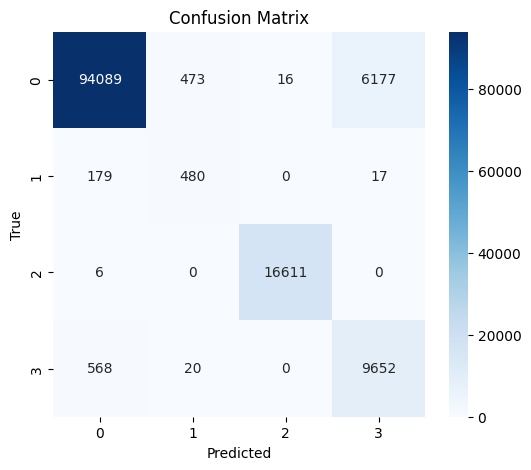

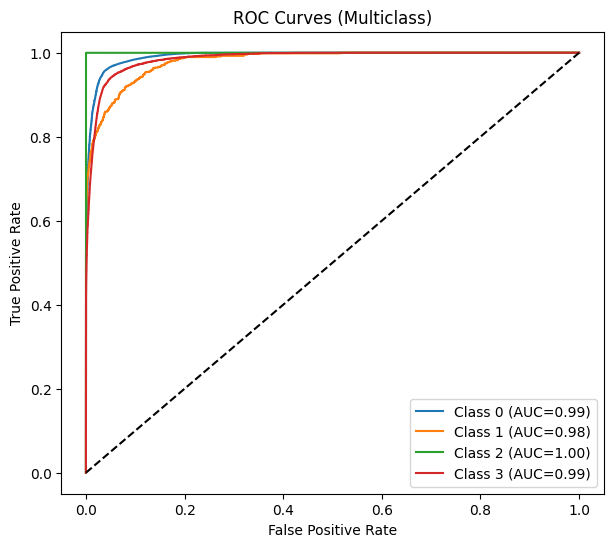

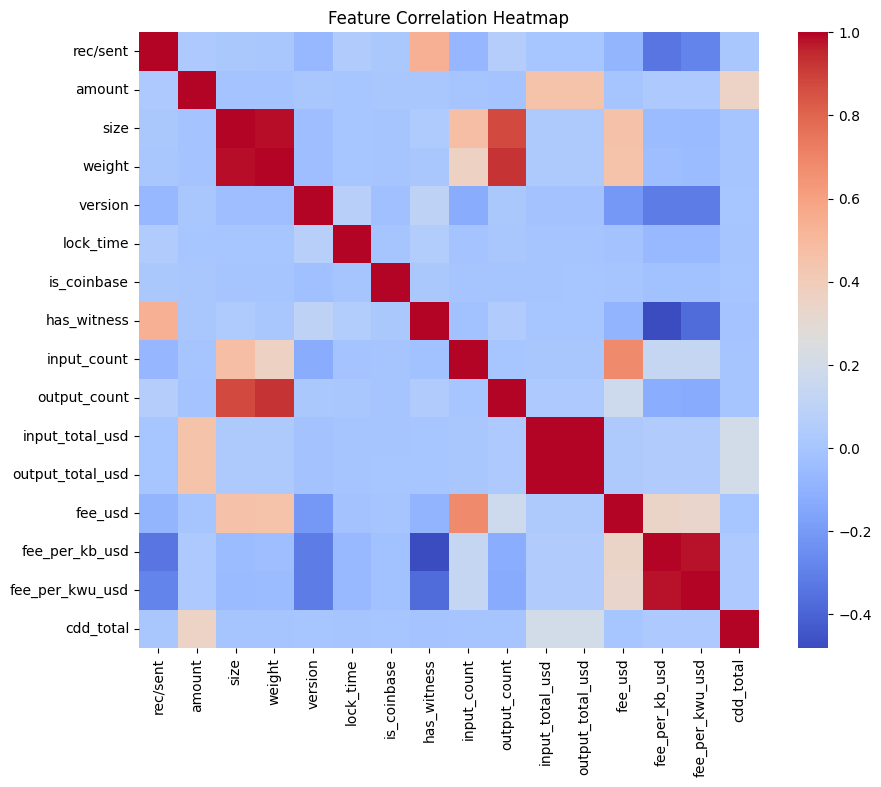

In [9]:
from time import time
from xgboost import XGBClassifier

# Start timer
current_time = time()

# Initialize the classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # avoid warning
model.fit(x_train, y_train.values.ravel())

# Predict the test dataset
y_pred = model.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=model,        # needed for ROC AUC
    x_test=x_test,      # needed for predict_proba
    x_train=x_train     # optional: for feature correlation heatmap
)


## Gradient Boosting


===== Evaluation Results =====
runtime_sec: 2383.9010
ram_used_mb: 262.3047
accuracy: 0.8724
precision: 0.9450
recall: 0.8724
roc_auc: 0.9821
confusion_matrix:
 [[85208  4363   258 10926]
 [  146   461     3    66]
 [    6     0 16611     0]
 [  461   136     8  9635]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.85      0.91    100755
           1       0.09      0.68      0.16       676
           2       0.98      1.00      0.99     16617
           3       0.47      0.94      0.62     10240

    accuracy                           0.87    128288
   macro avg       0.63      0.87      0.67    128288
weighted avg       0.95      0.87      0.90    128288



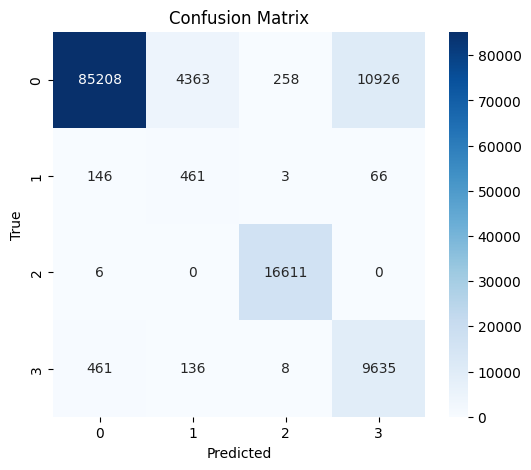

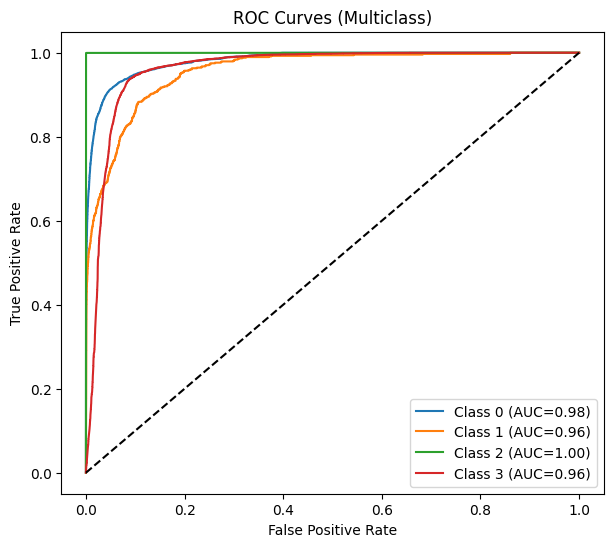

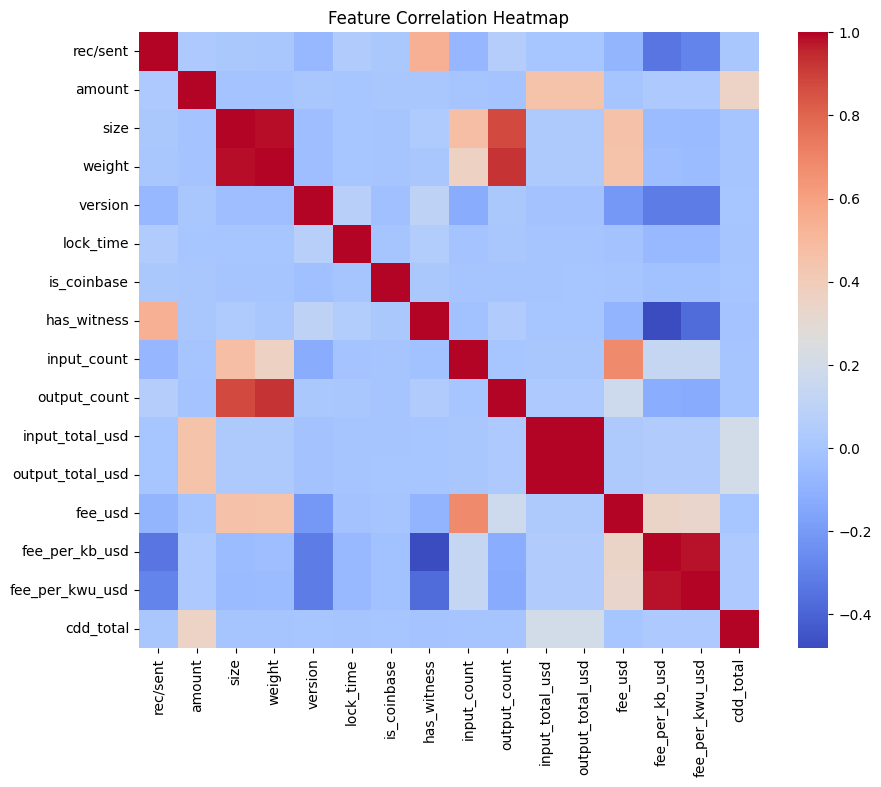

In [10]:
from time import time
from sklearn.ensemble import GradientBoostingClassifier

# Start timer
current_time = time()

# Initialize GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(x_train, y_train.values.ravel())  # flatten to 1D if needed

# Predict test dataset
y_pred = model.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=model,        # needed for ROC AUC
    x_test=x_test,      # needed for predict_proba
    x_train=x_train     # optional: feature correlation heatmap
)


## Extra Trees

F1-score: 0.8059890078271926

===== Evaluation Results =====
runtime_sec: 20.3874
ram_used_mb: 295.6445
accuracy: 0.7737
precision: 0.8946
recall: 0.7737
roc_auc: 0.9533
confusion_matrix:
 [[73540  5050  7765 14400]
 [  142   344    82   108]
 [    5   217 16395     0]
 [  592   277   388  8983]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.73      0.84    100755
           1       0.06      0.51      0.10       676
           2       0.67      0.99      0.79     16617
           3       0.38      0.88      0.53     10240

    accuracy                           0.77    128288
   macro avg       0.52      0.78      0.57    128288
weighted avg       0.89      0.77      0.81    128288



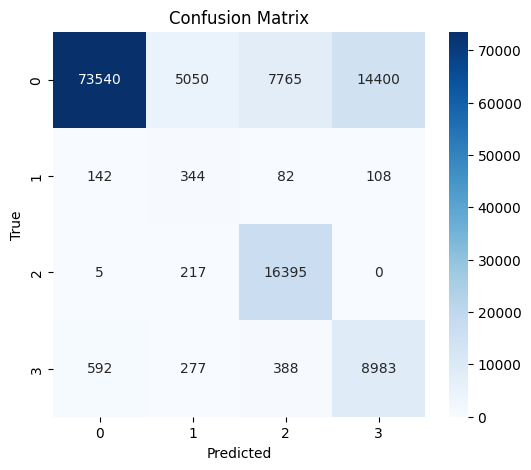

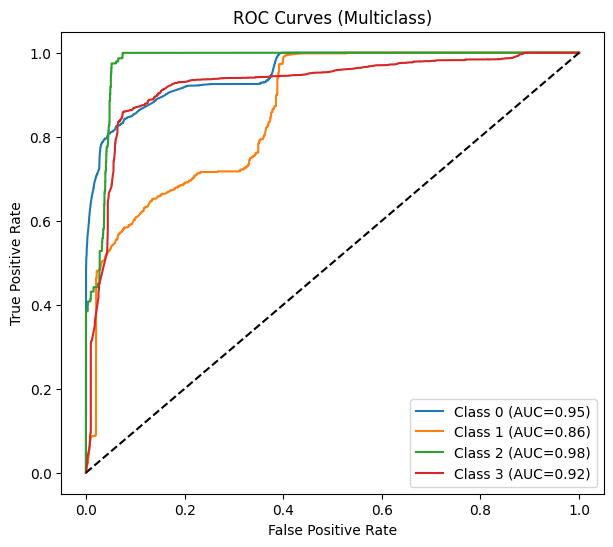

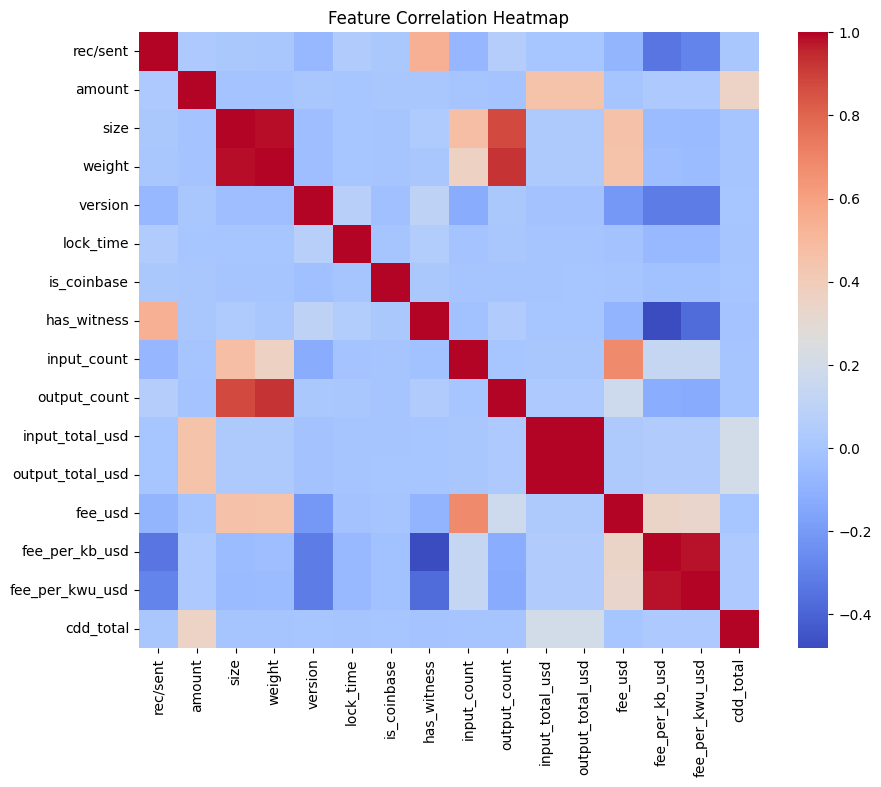

In [11]:
from time import time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score

# Start timer
current_time = time()

# Initialize ExtraTreesClassifier
clf = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

# Train the model
clf.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Predict test dataset
y_pred = clf.predict(x_test)

# Evaluate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

# Evaluate with check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=clf,        # needed for ROC AUC
    x_test=x_test,    # needed for predict_proba
    x_train=x_train   # optional: feature correlation heatmap
)


## Gaussian Naïve Bayes


===== Evaluation Results =====
runtime_sec: 0.4593
ram_used_mb: 367.9648
accuracy: 0.1972
precision: 0.8637
recall: 0.1972
roc_auc: 0.8850
confusion_matrix:
 [[22178 70997   879  6701]
 [    9   642    22     3]
 [    4 15142  1386    85]
 [  256  8835    55  1094]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.22      0.36    100755
           1       0.01      0.95      0.01       676
           2       0.59      0.08      0.15     16617
           3       0.14      0.11      0.12     10240

    accuracy                           0.20    128288
   macro avg       0.43      0.34      0.16    128288
weighted avg       0.86      0.20      0.31    128288



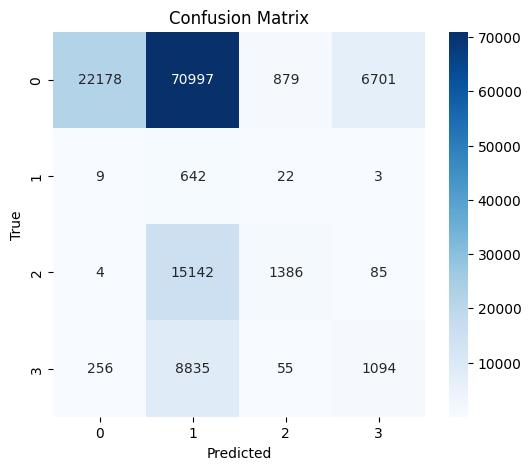

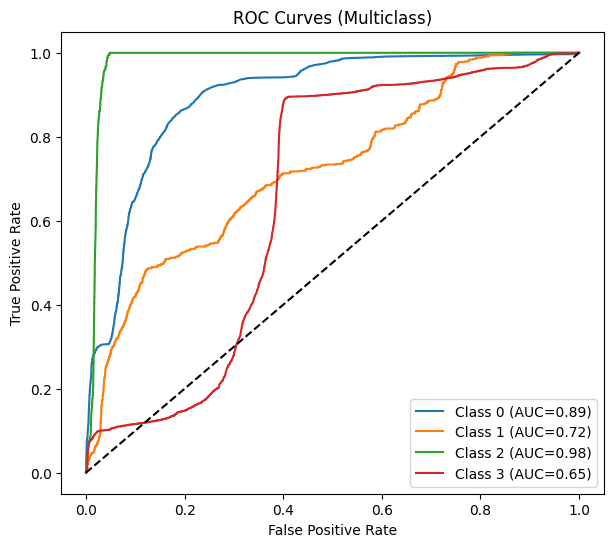

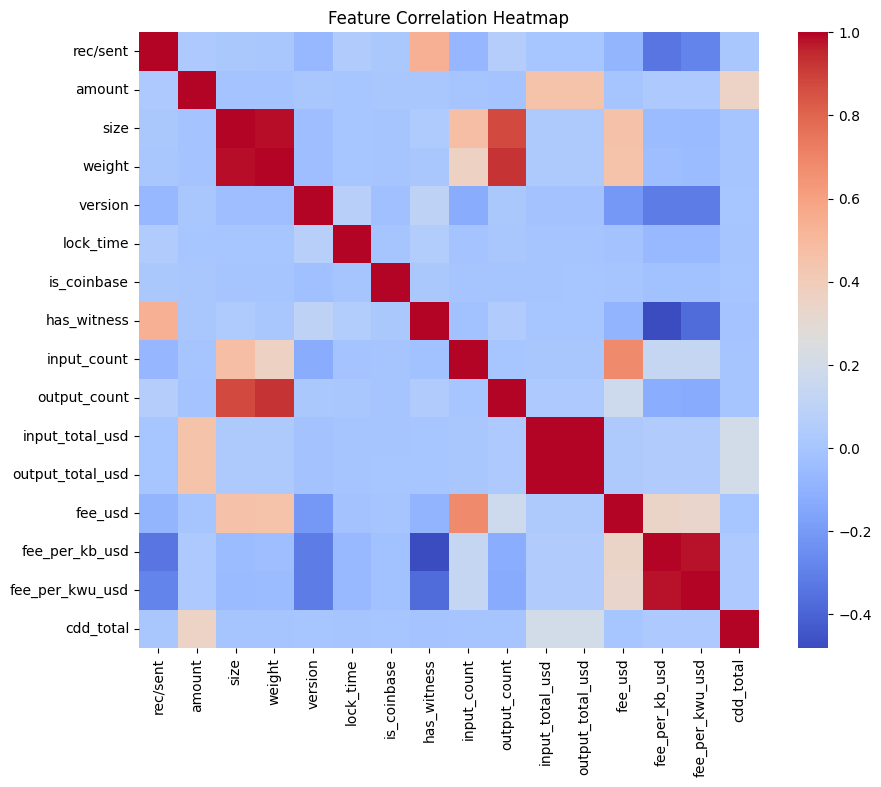

In [12]:
from time import time
from sklearn.naive_bayes import GaussianNB

# Start timer
current_time = time()

# Initialize Gaussian Naive Bayes
model = GaussianNB()

# Train the model
model.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Predict test dataset
y_pred = model.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=model,        # needed for ROC AUC
    x_test=x_test,      # needed for predict_proba
    x_train=x_train     # optional: feature correlation heatmap
)


## Classification and Regression Trees (CART)


===== Evaluation Results =====
runtime_sec: 4.8743
ram_used_mb: 382.0859
accuracy: 0.7451
precision: 0.9185
recall: 0.7451
roc_auc: 0.9199
confusion_matrix:
 [[70356 12263  2249 15887]
 [  108   383    99    86]
 [    5   123 16489     0]
 [  510  1216   159  8355]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.70      0.82    100755
           1       0.03      0.57      0.05       676
           2       0.87      0.99      0.93     16617
           3       0.34      0.82      0.48     10240

    accuracy                           0.75    128288
   macro avg       0.56      0.77      0.57    128288
weighted avg       0.92      0.75      0.80    128288



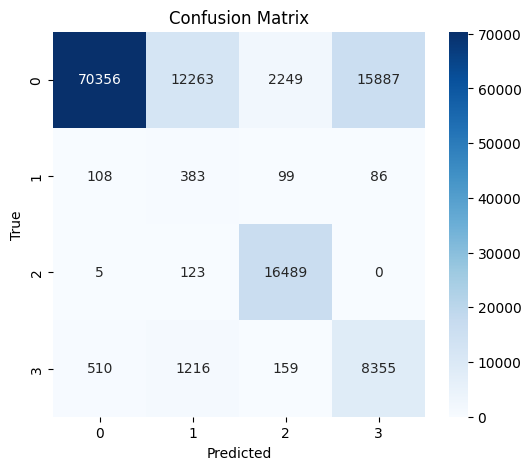

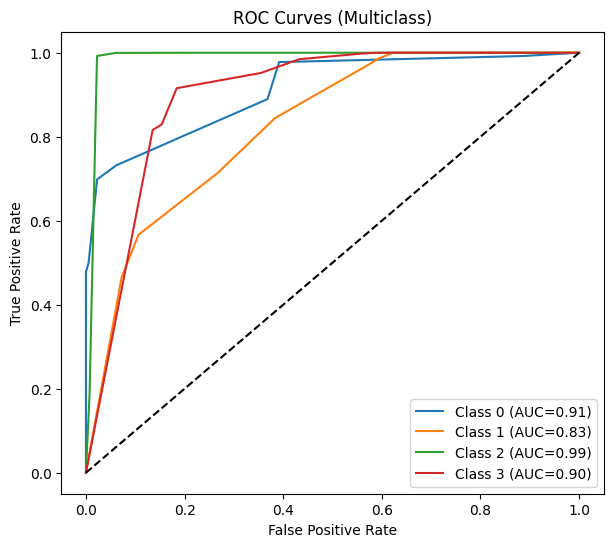

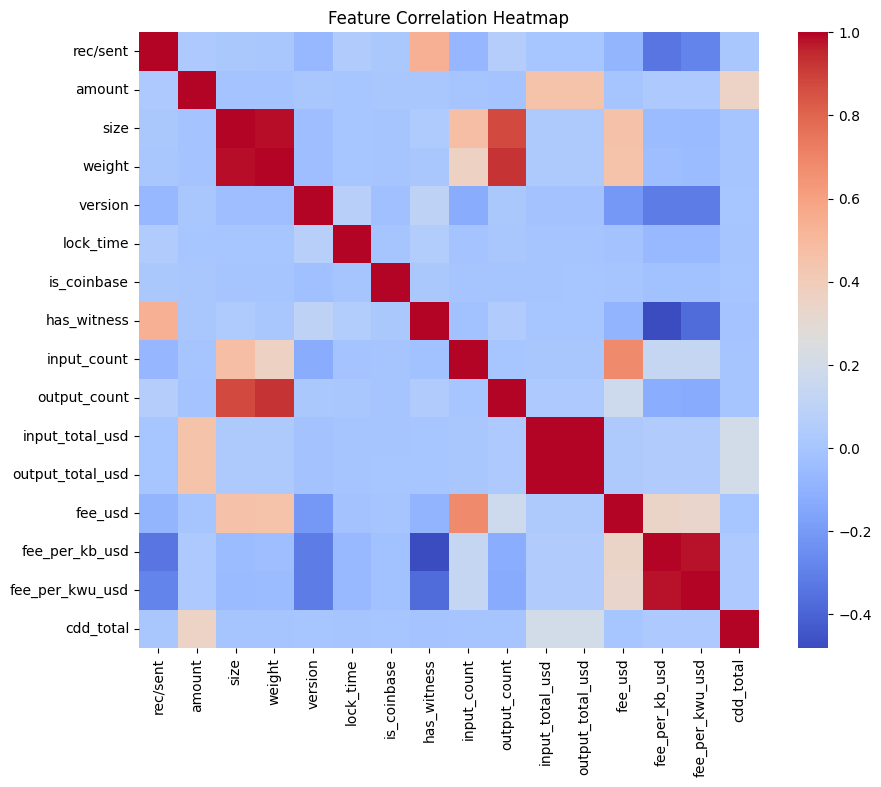

In [13]:
from time import time
from sklearn.tree import DecisionTreeClassifier

# Start timer
current_time = time()

# Create Decision Tree classifier
clf = DecisionTreeClassifier(max_depth=3)

# Fit the model
clf.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Make predictions on test data
y_pred = clf.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=clf,        # needed for ROC AUC
    x_test=x_test,    # needed for predict_proba
    x_train=x_train   # optional: feature correlation heatmap
)


## K-Nearest Neighbours


===== Evaluation Results =====
runtime_sec: 91.4100
ram_used_mb: 510.6445
accuracy: 0.9461
precision: 0.9560
recall: 0.9461
roc_auc: 0.9673
confusion_matrix:
 [[95612   850    15  4278]
 [  219   433     5    19]
 [   15     0 16602     0]
 [ 1493    26     0  8721]]


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    100755
           1       0.33      0.64      0.44       676
           2       1.00      1.00      1.00     16617
           3       0.67      0.85      0.75     10240

    accuracy                           0.95    128288
   macro avg       0.75      0.86      0.79    128288
weighted avg       0.96      0.95      0.95    128288



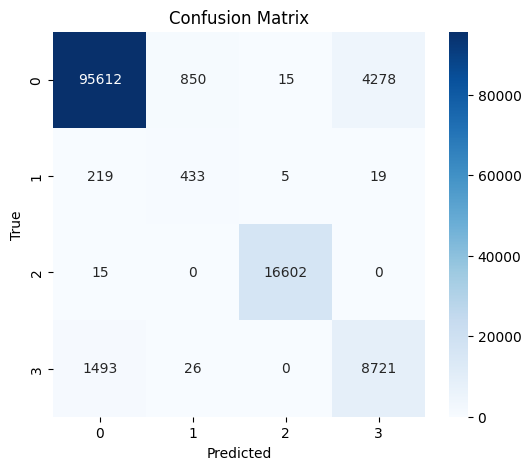

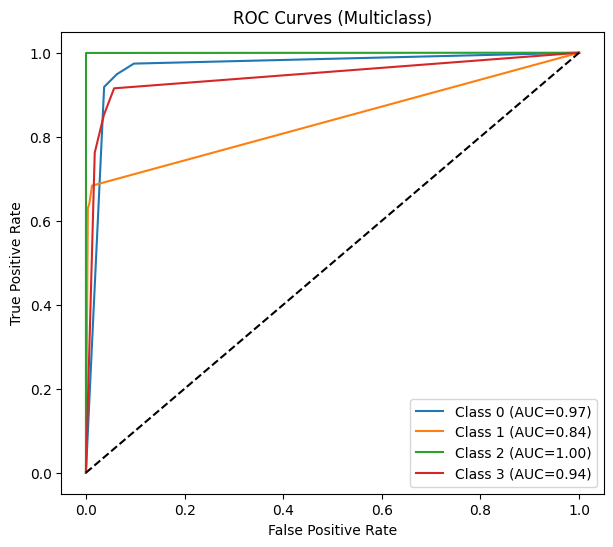

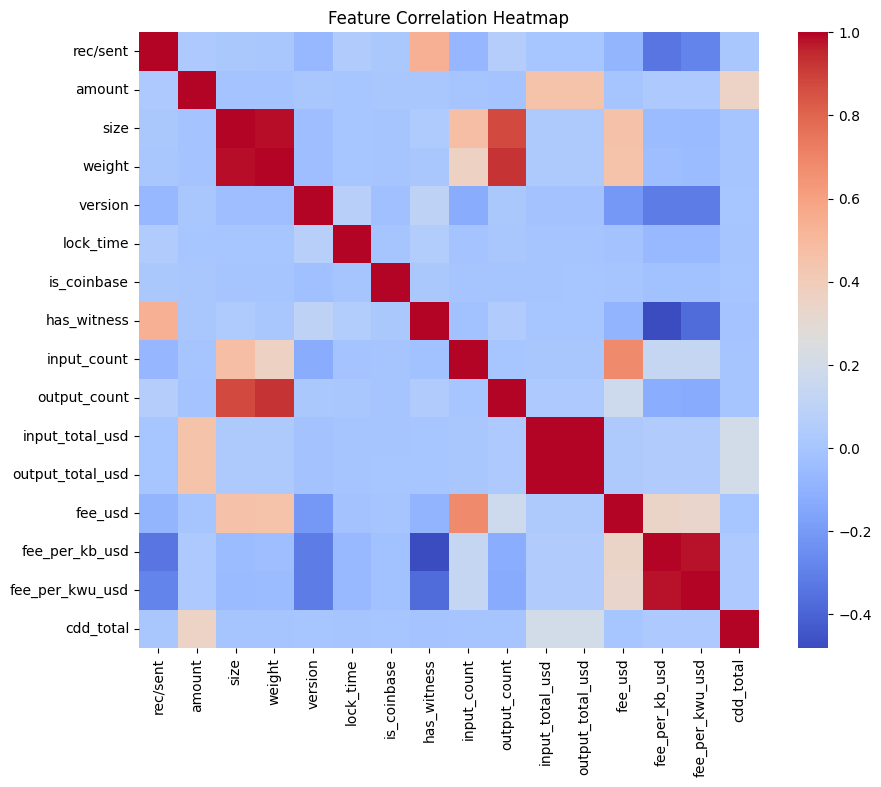

In [14]:
from time import time
from sklearn.neighbors import KNeighborsClassifier

# Start timer
current_time = time()

# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model
knn.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Predict the test dataset
y_pred = knn.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=knn,        # needed for ROC AUC
    x_test=x_test,    # needed for predict_proba
    x_train=x_train   # optional: feature correlation heatmap
)


##  Adaboost


===== Evaluation Results =====
runtime_sec: 102.3329
ram_used_mb: 516.5820
accuracy: 0.7054
precision: 0.9271
recall: 0.7054
roc_auc: 0.9302
confusion_matrix:
 [[65317 14339   779 20320]
 [   89   453     8   126]
 [  127  1140 15350     0]
 [  311   505    55  9369]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.65      0.78    100755
           1       0.03      0.67      0.05       676
           2       0.95      0.92      0.94     16617
           3       0.31      0.91      0.47     10240

    accuracy                           0.71    128288
   macro avg       0.57      0.79      0.56    128288
weighted avg       0.93      0.71      0.77    128288



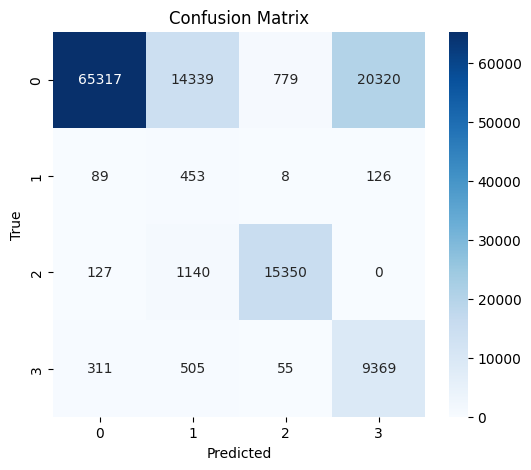

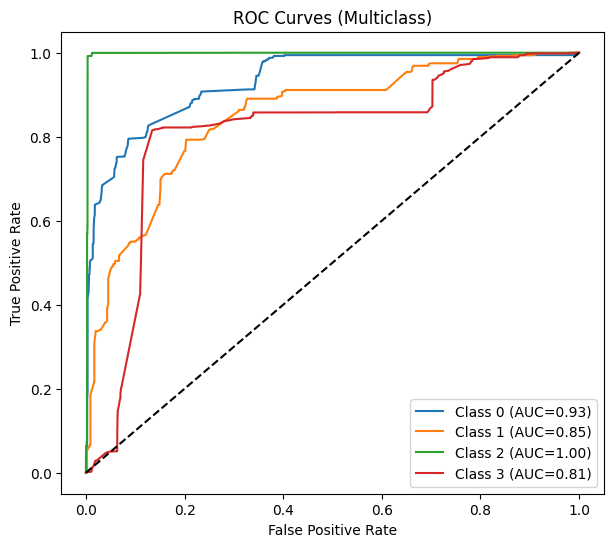

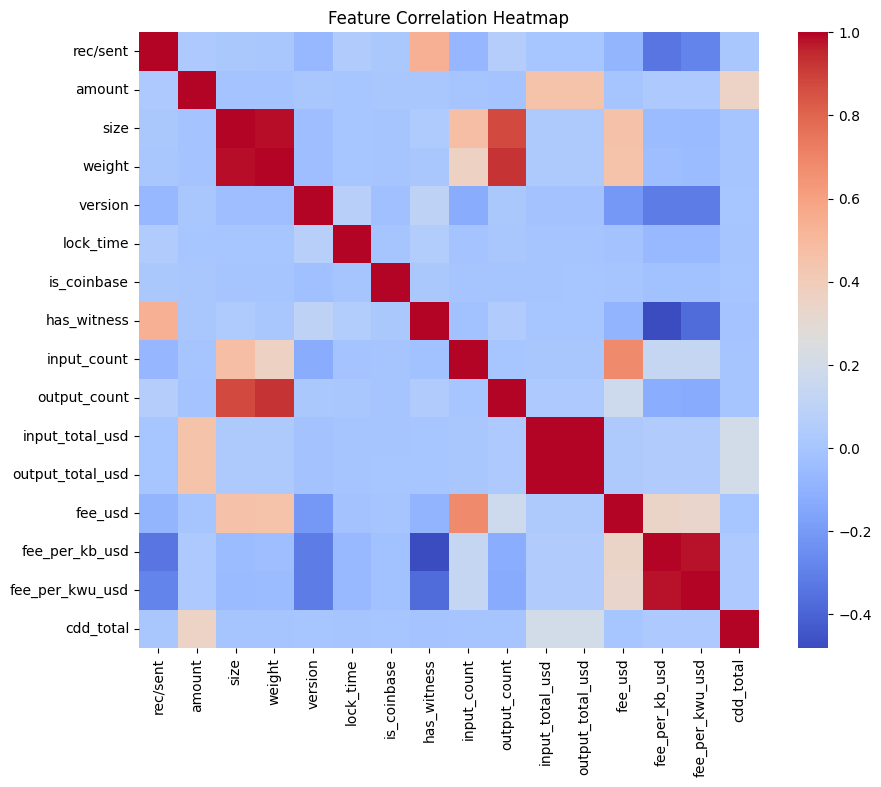

In [15]:
from time import time
from sklearn.ensemble import AdaBoostClassifier

# Start timer
current_time = time()

# Initialize AdaBoost classifier
adboost = AdaBoostClassifier()
adboost.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Predict the test dataset
y_pred = adboost.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=adboost,    # needed for ROC AUC
    x_test=x_test,    # needed for predict_proba
    x_train=x_train   # optional: feature correlation heatmap
)
